In [1]:
using PyPlot
using Distributions
using LinearAlgebra

- 多変量ガウス分布の基本的な期待値

\begin{align}
\left \langle \mathbf{x} \right \rangle &= \boldsymbol{\mu} \\
\left \langle \mathbf{xx}^T \right \rangle &= \boldsymbol{\mu \mu}^T +\mathbf{\Sigma} \\
\end{align}

\begin{align}
\because
\mathbf{\Sigma} &= \left \langle (\mathbf{x} - \langle  \mathbf{x}  \rangle)(\mathbf{x} -  \langle \mathbf{x} \rangle)^T \right \rangle \\
&=\langle \mathbf{xx}^T \rangle - \langle \mathbf{x} \rangle \langle \mathbf{x}^T  \rangle \\
\end{align}

# KL divergence

\begin{align}
KL[q(\mathbf x)\|p(\mathbf x)] &= -\int q(\mathbf x) \ln \frac{p(\mathbf x)}{q(\mathbf x)}d \mathbf x \\
&= \left \langle  \ln q(\mathbf x) \right \rangle _{q(\mathbf x)} - \left \langle \ln p(\mathbf x) \right \rangle _{q(\mathbf x)} 
\end{align}

- 多変量ガウス分布のKL divergence

\begin{align}
KL[q(\mathbf x)\|p(\mathbf x)] &= \left \langle  \ln q(\mathbf x) \right \rangle _{q(\mathbf x)} - \left \langle \ln p(\mathbf x) \right \rangle _{q(\mathbf x)} 
\end{align}

In [2]:
function calc_KL(μ₁, λ₁, μ₂, λ₂)
    D = size(μ₁, 1)
    KL = (1/2) * ((μ₁ - μ₂)' * λ₁ * (μ₁ - μ₂)) .+ (tr(λ₂ * inv(λ₁)) + logdet(λ₁) - logdet(λ₂) - D)
    return KL[1]
end

calc_KL (generic function with 1 method)

In [3]:
function plot_results(result, truth)
    N = size(result, 1)
    H = Int(ceil(sqrt(N)))
    W = Int(ceil(N / H))
    for i in 1:H
        for j in 1:W
            n = (i - 1) * W + j
            if n <= N
                title("$n of $N")
                plot_gaussian(truth[1], truth[2], "b", "\$p(z)\$")
                plot_gaussian(result[n][1], result[n][2], "r", "\$p(z)\$")
            end
        end    
    end
end

plot_results (generic function with 1 method)

In [4]:
function plot_gaussian(μ, λ, col, label)
    res = 100
    plot(μ[1], μ[2], "x", color=col)
    
    F = eigen(λ)
    vec = F.vectors
    val = F.values
    dw = 2 * pi/res
    w = dw * (0 : res)
    c = 1.0
    a = sqrt(c*val[1])
    b = sqrt(c*val[2])
    P1 = a*cos.(w)
    P2 = b*sin.(w)
    P = μ .+ vec'*vcat(P1', P2')
    plot(P[1, :], P[2, :], "-", color=col, label=label)
end

plot_gaussian (generic function with 1 method)

In [5]:
function main_VI()
    D = 2
    θ = 2.0 * pi / 12

    A = [cos(θ) -sin(θ);
        sin(θ) cos(θ)]
    μ = [0.0, 0.0]
    λ = inv(A * inv([1 0; 0 10])* A')

    μₕ = [-0.5, 0.3]
    λₕ = zeros(D, D)

    max_iter = 100
    KL = NaN * Array{Float64}(undef, max_iter)
    result = Array{Any}(undef, max_iter)

    for i in 1:max_iter
        μₕ[1] = μ[1] - inv(λ[1, 1]) * λ[1, 2] * (μₕ[2] - μ[2])
        λₕ[1, 1] = λ[1, 1]
        μₕ[2] = μ[2] - inv(λ[2, 2]) * λ[2, 1] * (μₕ[1] - μ[1])
        λₕ[2, 2] = λ[2, 2]
        KL[i] = calc_KL(μₕ, λₕ, μ, λ)
        result[i] = [deepcopy(μₕ), deepcopy(inv(λₕ))]
    end
    figure("result per iteration VI")
    clf()
    plot_results(result, (μ, inv(λ)))

    figure("result VI")
    clf()
    plot_gaussian(μ, inv(λ), "b", "\$p(\\bf{z})\$")
    plot_gaussian(result[end][1], result[end][2], "r", "\$q(\\bf{z})\$")

    xlabel("\$z_1\$", fontsize=20)
    ylabel("\$z_2\$", fontsize=20)
    legend(fontsize=16)


    figure("KL divergence VI")
    clf()
    plot(1:max_iter, KL)
    ylabel("KL divergence", fontsize=16)
    xlabel("iteration", fontsize=16)


    show()
end

main_VI (generic function with 1 method)

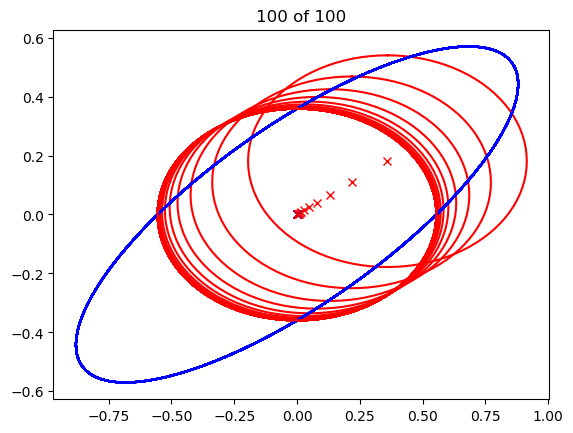

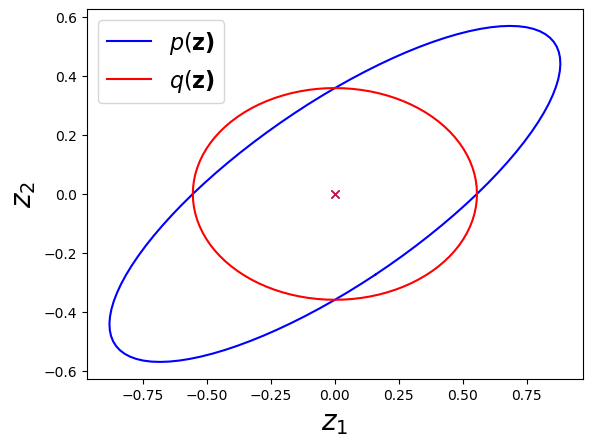

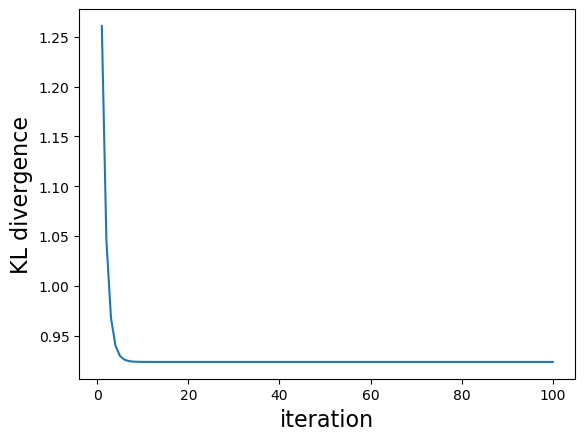

In [6]:
main_VI()

In [7]:
function plot_lines(X)
    D, N = size(X)
    X_d = zeros(D, 2*N + 1)
    X_d[:,1] = X[:,1]
    for i in 1 : N
        X_d[1, 2*i - 1] = X[1, i]
        X_d[1, 2*i] = X[1, i]
        X_d[2, 2*i] = X[2, i]
        X_d[2, 2*i + 1] = X[2, i]
    end
    plot(X[1,:], X[2,:], "oy")
    plot(X_d[1,1:2*N], X_d[2,1:2*N], "--y")
end


plot_lines (generic function with 1 method)

In [8]:
function main_GS()
    D = 2
    θ = 2.0 * pi / 12

    A = [cos(θ) -sin(θ);
        sin(θ) cos(θ)]
    μ = [0.0, 0.0]
    λ = inv(A * inv([1 0; 0 10])* A')


    max_iter = 1000
    X = randn(D, max_iter)
    μₕ = randn(D)
    KL = NaN * Array{Float64}(undef, max_iter)

    for i in 2:max_iter
        μₕ[1] = μ[1] - inv(λ[1, 1]) * λ[1, 2] * (X[2, i-1] - μ[2])
        X[1, i] = rand(Normal(μₕ[1], sqrt(inv(λ[1, 1]))))

        μₕ[2] = μ[2] - inv(λ[2, 2]) * λ[2, 1] * (X[1, i-1] - μ[1])
        X[2, i] = rand(Normal(μₕ[2], sqrt(inv(λ[2, 2]))))

        if i > D
            KL[i] = calc_KL(mean(X[:, 1:i], dims=2), inv(cov(X[:, 1:i], dims=2)), μ, λ)
        end
    end

    μₑ = mean(X, dims=2)
    σₑ = cov(X, dims=2)

    figure("samples GS")
    clf()
    plot_lines(X)
    plot_gaussian(μ, inv(λ), "b", "\$p(\\bf{z})\$")
    plot_gaussian(μₑ, σₑ, "r", "\$q(\\bf{z})\$")
    xlabel("\$z_1\$", fontsize=20)
    ylabel("\$z_2\$", fontsize=20)
    legend(fontsize=16)

    figure("KL divergence (GS)")
    clf()
    plot(1:max_iter, KL)
    ylabel("KL divergence", fontsize=16)
    xlabel("sample size", fontsize=16)
    show()
end

main_GS (generic function with 1 method)

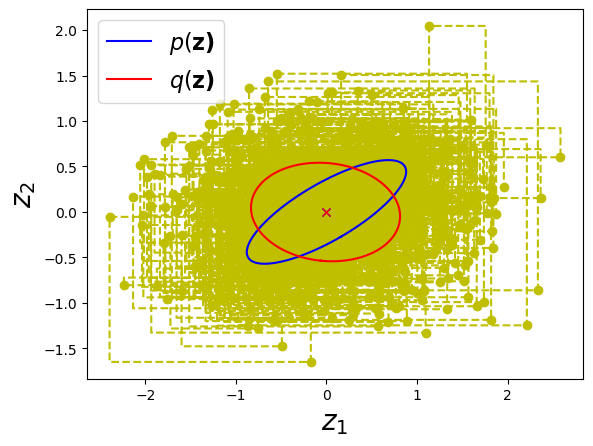

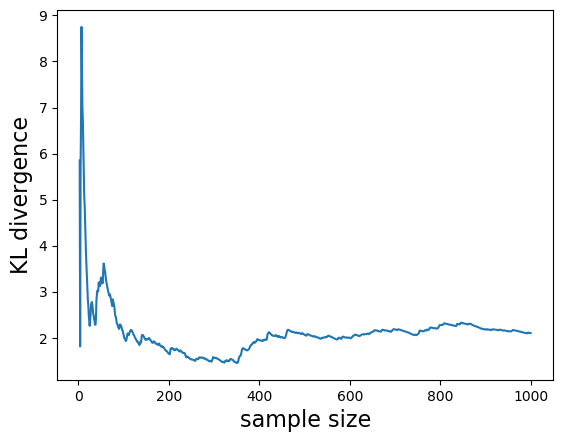

In [9]:
main_GS()